Tutorial 8: Fitting
===================

Up to now, we have used profiles, galaxies and tracers to create images of a strong lens. However, this is the opposite
of what most Astronomers do: normally, an Astronomer has observed an image of a strong lens, and their goal is to
determine the profiles that best represent the mass distribution of the lens galaxy and source light distribution of
the source galaxy.

To do this, we need to fit the data and determine which light and mass profiles best represent the image it contains.
We'll demonstrate how to do this using the imaging data we simulated in the previous tutorial. By comparing the images
that come out of a tracer with the data, we'll compute diagnostics that tell us how good or bad a combination of light
and mass profiles represent the strong lens we observed.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

The `dataset_path` specifies where the data was output in the last tutorial, which is the directory 
`autolens_workspace/dataset/imaging/no_lens_light/howtolens/`.

In [2]:
dataset_path = path.join("dataset", "imaging", "no_lens_light", "howtolens")

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Imaging Dataset__

The `Imaging` object packages all components of an imaging dataset, in particular:

 1) The image.
 2) Its noise-map.
 3) The Point Spread Function (PSF).
    
The image and noise map are stored as an `Array2D` object, whereas the PSF is a `Kernel2D`, meaning it can be used to
perform 2D convolution.

In [3]:
print("Image:")
print(type(imaging.image))
print("Noise-Map:")
print(type(imaging.noise_map))
print("PSF:")
print(type(imaging.psf))

Image:
<class 'autoarray.structures.arrays.two_d.array_2d.Array2D'>
Noise-Map:
<class 'autoarray.structures.arrays.two_d.array_2d.Array2D'>
PSF:
<class 'autoarray.structures.kernel_2d.Kernel2D'>


The `ImagingPlotter` can plot all of these attributes on a single subplot:

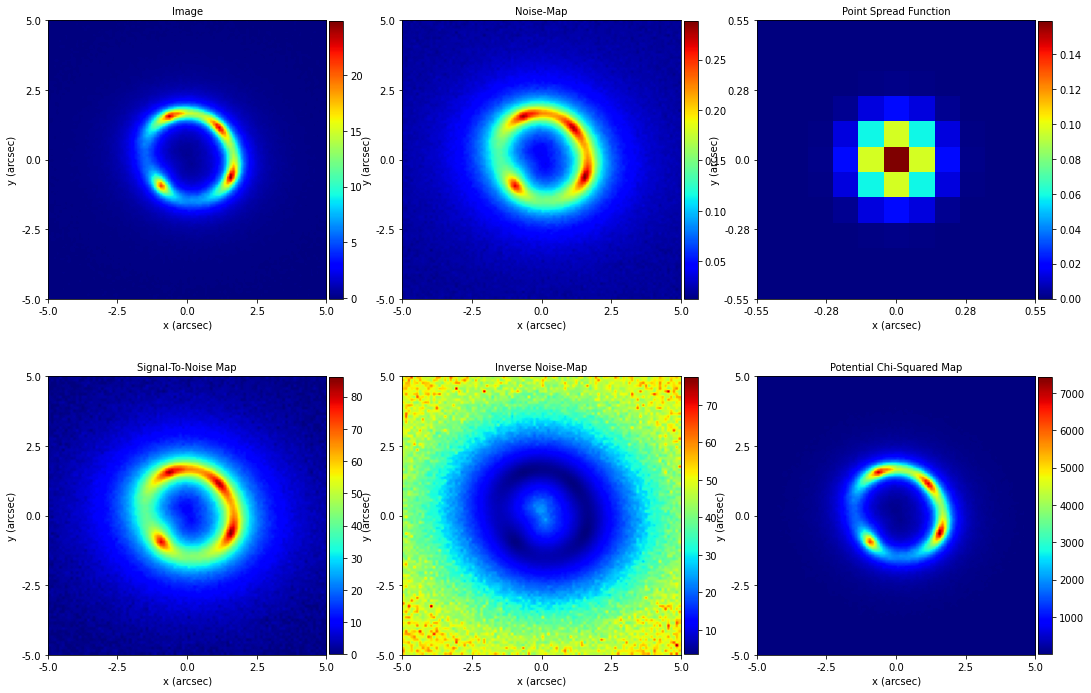

In [4]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Masking__

To fit an image, we must first specify a `Mask2D`, which removes certain regions of the image such that they are not 
included in the fit. We therefore want to mask out the regions of the image where the lens and source galaxies are not 
visible, for example the edges.

For the image we simulated a 3" circular mask will do the job.

In [5]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

print(mask)  # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53])  # Whereas central pixels are `False` and therefore unmasked.

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


We can use an `ImagingPlotter` to compare the mask and the image, which is useful if we want to `tailor` a mask to 
the lensed source's light (in this example, we do not do this, but there are examples of how to do this throughout
the `autolens_workspace`).

However, the mask is not currently attribute of the imaging and we cannot use the code `Include2D(mask=True)` to plot 
it. The imaging doesn't know what the mask is!

To manually plot an object over the figure of another object, we can use the `Visuals2D` object, which we used in a 
previous tutorial to plot certain pixels on an image and source plane. The `Visuals2D` object can be used to customize 
the appearance of *any* figure in **PyAutoLens** and is therefore a powerful means by which to create custom visuals!

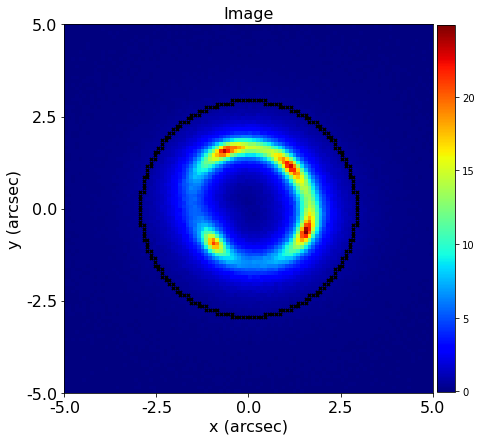

In [6]:
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.figures_2d(image=True)

Before we can fit the imaging data we need to apply the mask to it, which is done using the `apply_mask` method. 

In addition to removing the regions of the image we do not want to fit, this also creates a new grid in the imaging 
data that consists only of image-pixels that are not masked. This grid is used for performing ray-tracing calculations
when we fit the data.

In [7]:
imaging = imaging.apply_mask(mask=mask)

Now the mask is an attribute of the imaging data we can plot it using the `Include2D` object.

Because it is an attribute, the `mask` now also automatically `zooms` our plot around the masked region only. This 
means that if our image is very large, we focus-in on the lens and source galaxies.

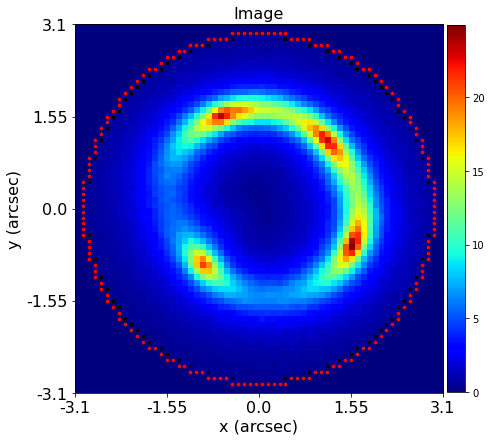

In [8]:
include_2d = aplt.Include2D(mask=True)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, include_2d=include_2d)
imaging_plotter.figures_2d(image=True)

By printing its attributes, we can see that the imaging contains everything we need to fit: a mask, the masked image, 
masked noise-map and psf.

In [9]:
print("Mask2D")
print(imaging.mask)
print()
print("Masked Image:")
print(imaging.image)
print()
print("Masked Noise-Map:")
print(imaging.noise_map)
print()
print("PSF:")
print(imaging.psf)
print()

Mask2D
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Masked Image:
[0.39820822 0.49676161 0.56426892 ... 0.36339752 0.36117546 0.36951393]

Masked Noise-Map:
[0.04075161 0.04460051 0.0470556  ... 0.03930214 0.0392078  0.03956067]

PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e

__Masked Data Structures__

This image and noise-map again have `native` and `slim` representations. However, the `slim` representation now takes
on a slightly different meaning, it only contains image-pixels that were not masked. This can be seen by printing
the `shape_slim` attribute of the image, and comparing it to the `pixels_in_mask` of the mask.

In [10]:
print("The number of unmasked pixels")
print(imaging.image.shape_slim)
print(imaging.noise_map.shape_slim)
print(imaging.image.mask.pixels_in_mask)

The number of unmasked pixels
2828
2828
2828


We can use the `slim` attribute to print certain values of the image:

In [11]:
print("First unmasked image value:")
print(imaging.image.slim[0])
print("First unmasked noise-map value:")
print(imaging.noise_map.slim[0])

First unmasked image value:
0.398208219664564
First unmasked noise-map value:
0.040751614269235355


The `native` representation of the image `Array2D` retains the dimensions [total_y_image_pixels, total_x_image_pixels], 
however the exterior pixels have values of 0.0 indicating that they have been masked.

In [12]:
print("Example masked pixels in the image's native representation:")
print(imaging.image.shape_native)
print(imaging.image.native[0, 0])
print(imaging.image.native[2, 2])
print("Example masked noise map values in its native representation:")
print(imaging.noise_map.native[0, 0])

Example masked pixels in the image's native representation:
(100, 100)
0.0
0.0
Example masked noise map values in its native representation:
0.0


The masked imaging also has a `Grid2D`, where only coordinates which are not masked are included (the masked values 
in the native representation are set to [0.0. 0.0] to indicate they are masked).

In [13]:
print("Masked imaging's grid")
print(imaging.grid.slim)
print(imaging.grid.native)

Masked imaging's grid
[[ 2.95 -0.45]
 [ 2.95 -0.35]
 [ 2.95 -0.25]
 ...
 [-2.95  0.25]
 [-2.95  0.35]
 [-2.95  0.45]]
[[[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 ...

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  ...
  [0. 0.]
  [0. 0.]
  [0. 0.]]]


__Fitting__

To fit an image, create an image using a tracer. Lets use the same tracer that we simulated the imaging with in the
previous tutorial, which will give us a 'perfect' fit.

Its worth noting that below, we use the masked imaging's grid to setup the tracer. This ensures that our image-plane 
image is the same resolution and alignment as our lens data's masked image and that the image is only created in
unmasked pixels.

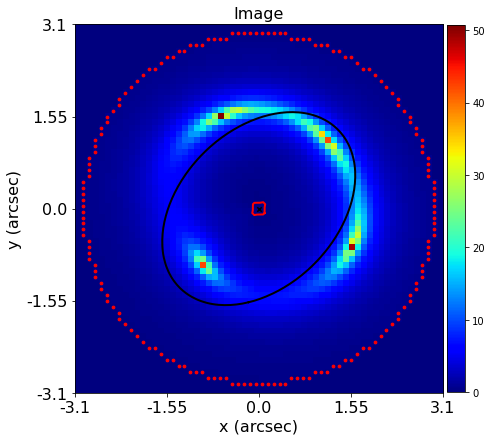

In [14]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)


tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=imaging.grid)
tracer_plotter.figures_2d(image=True)

To fit the image, we pass the `Imaging` and `Tracer` to a `FitImaging` object. This performs the following:

 1) Blurs the tracer`s image with the data's PSF, ensuring the telescope optics are included in the fit. This 
 creates what is called the `model_image`.

 2) Computes the difference between this model-image and the observed image, creating the fit`s `residual_map`.

 3) Divides the residual-map by the noise-map, creating the fit`s `normalized_residual_map`.

 4) Squares every value in the normalized residual-map, creating the fit's `chi_squared_map`.

 5) Sums up these chi-squared values and converts them to a `log_likelihood`, which quantifies how good this tracer`s 
 fit to the data was (higher log_likelihood = better fit).

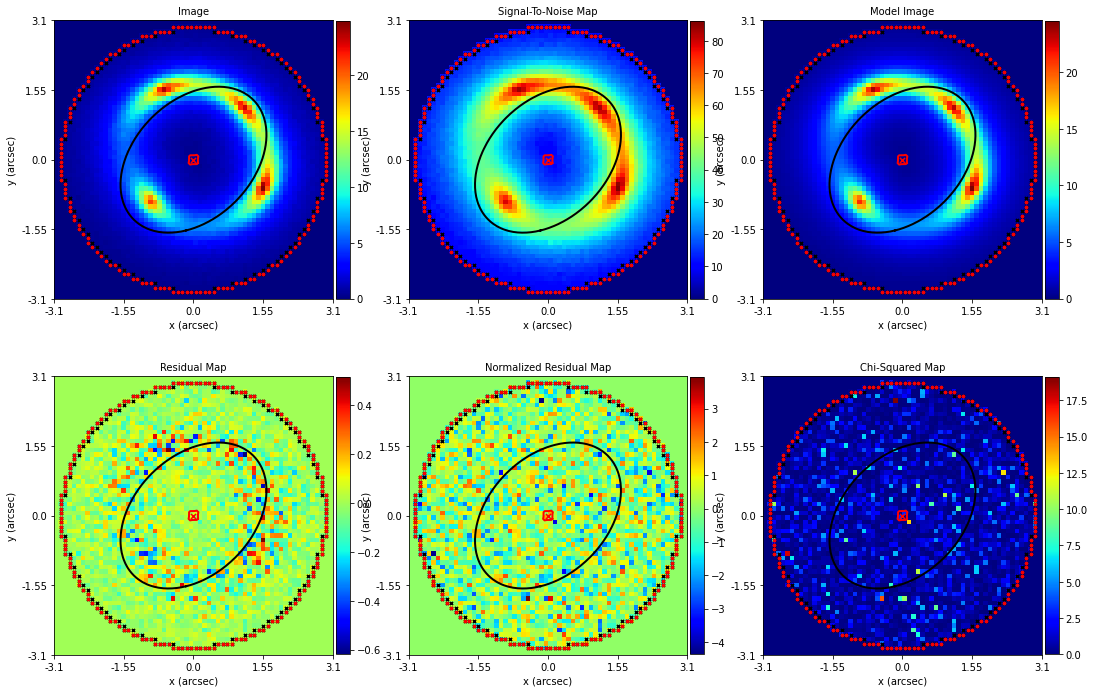

In [15]:
fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

We can print the fit`s attributes. As usual, we can choose whether to return the fits in slim or native format, with
the native data's edge values all zeros, as the edges were masked:

In [16]:
print("Model-Image:")
print(fit.model_image.slim)
print(fit.model_image.native)
print()
print("Residual Maps:")
print(fit.residual_map.slim)
print(fit.residual_map.native)
print()
print("Chi-Squareds Maps:")
print(fit.chi_squared_map.slim)
print(fit.chi_squared_map.native)

Model-Image:
[0.47243744 0.48004747 0.48546779 ... 0.34836542 0.3472544  0.34475697]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Residual Maps:
[-0.07422922  0.01671414  0.07880113 ...  0.01503209  0.01392107
  0.02475697]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Chi-Squareds Maps:
[3.31787638 0.14043921 2.80441423 ... 0.14628721 0.1260666  0.39162249]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Of course, the central unmasked pixels have non-zero values.

In [17]:
model_image = fit.model_image.native
print(model_image[48:53, 48:53])
print()

residual_map = fit.residual_map.native
print("Residuals Central Pixels:")
print(residual_map[48:53, 48:53])
print()

print("Chi-Squareds Central Pixels:")
chi_squared_map = fit.chi_squared_map.native
print(chi_squared_map[48:53, 48:53])

[[0.50683579 0.4346109  0.44064346 0.52137693 0.63741756]
 [0.59106205 0.48554054 0.46079763 0.52547789 0.63026684]
 [0.70554677 0.56118043 0.49209993 0.52582398 0.61565668]
 [0.77719043 0.6079018  0.52005247 0.53427589 0.61140966]
 [0.81964506 0.65108216 0.56930465 0.57545588 0.64038831]]

Residuals Central Pixels:
[[-0.04983087 -0.00205577 -0.02268987 -0.00528973  0.1007509 ]
 [ 0.04772872  0.00220721  0.08079763  0.01881122 -0.02639983]
 [ 0.02221344  0.0878471   0.00209993  0.02249065 -0.02434332]
 [ 0.0238571   0.02123514  0.01671914 -0.14572411 -0.00525701]
 [ 0.02964506  0.06108216  0.00597132 -0.03121079 -0.03961169]]

Chi-Squareds Central Pixels:
[[1.33739346e+00 2.38069712e-03 2.98190983e-01 1.36253237e-02
  3.63318717e+00]
 [9.25037588e-01 2.48666712e-03 3.05251168e+00 1.64768618e-01
  2.97052309e-01]
 [1.78833223e-01 3.09085272e+00 2.22638502e-03 2.34066572e-01
  2.57161450e-01]
 [1.89499801e-01 1.85533456e-01 1.31693814e-01 1.30398774e+01
  1.17408555e-02]
 [2.77732630e-01

The fit also gives a `log_likelihood`, which is a single-figure estimate of how good the model image fitted the 
imaging data (in unmasked pixels only!).

In [18]:
print("Likelihood:")
print(fit.log_likelihood)

Likelihood:
2936.606509247931


__Fitting (incorrect fit)__

We used the same tracer to create and fit the image, giving an excellent fit. The residual-map and chi-squared-map
showed no signs of the source-galaxy's light being left over. This solution will translate to one of the highest 
log likelihood solutions possible.

Lets change the tracer, so that it is near the correct solution, but slightly off. Below, we slightly offset the lens 
galaxy, by 0.005"

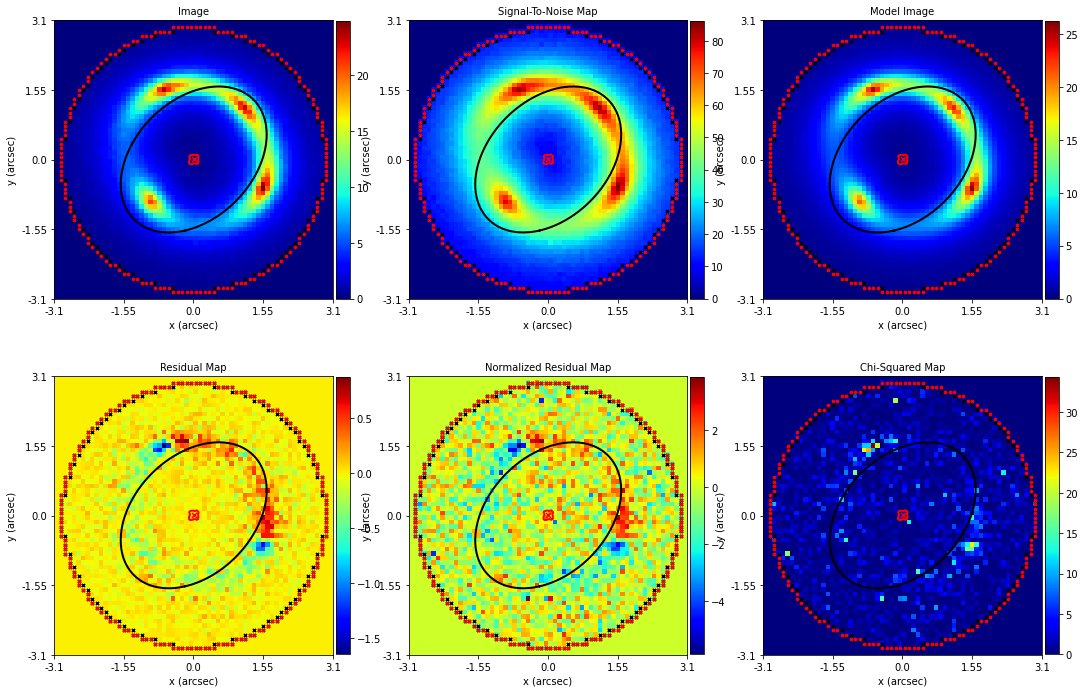

In [19]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.005, 0.005), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)


tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

Residuals now appear at the locations of the source galaxy, increasing the chi-squared values (which determine 
our log_likelihood).

Lets compare the log likelihood to the value we computed above (which was 2967.0488):

In [20]:
print("Previous Likelihood:")
print(2967.0488)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihood:
2967.0488
New Likelihood:
2528.7035349606576


It decreases! As expected, this model is a worse fit to the data.

Lets change the tracer, one more time, to a solution nowhere near the correct one.

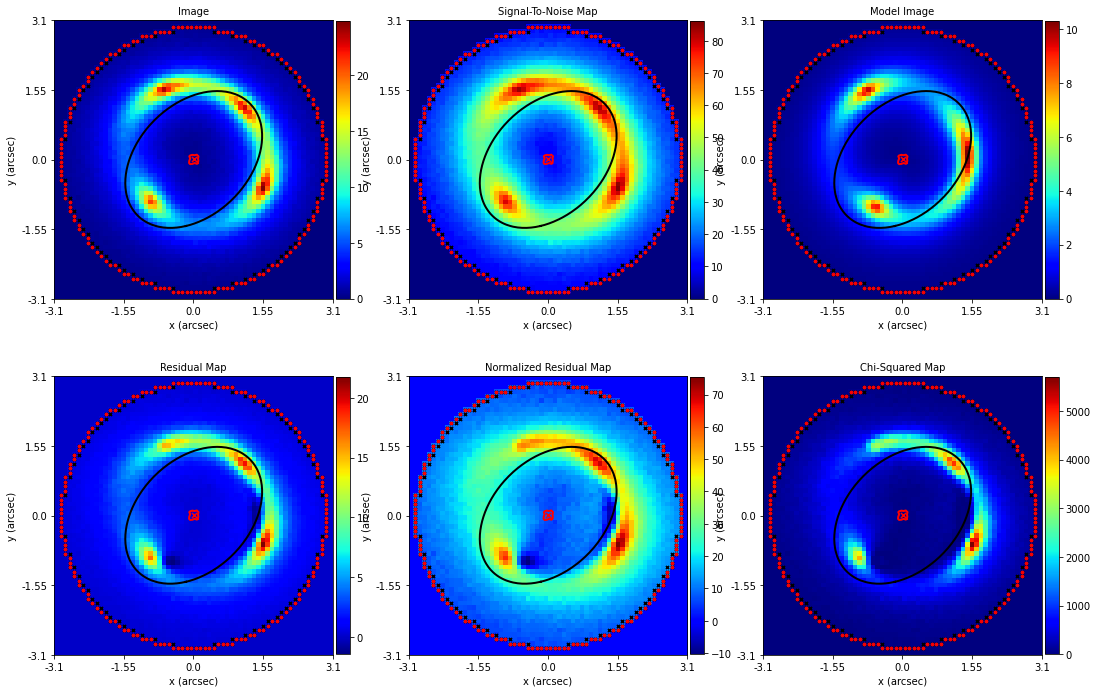

In [21]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.005, 0.005),
        einstein_radius=1.5,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, angle=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.2, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.5,
        effective_radius=0.8,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

Clearly, the model provides a terrible fit and this tracer is not a plausible representation of our strong lens dataset
(of course, we already knew that, given that we simulated it!)

The log likelihood drops dramatically, as expected.

In [22]:
print("Previous Likelihoods:")
print(2967.0488)
print(2687.4724)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihoods:
2967.0488
2687.4724
New Likelihood:
-655800.4183538017


__Wrap Up__

Congratulations, you`ve fitted your first strong lens with **PyAutoLens**! Perform the following exercises:

 1) In this example, we `knew` the correct solution, because we simulated the lens ourselves. In the real Universe, 
 we have no idea what the correct solution is. How would you go about finding the correct solution? Could you find a 
 solution that fits the data reasonable through trial and error?